# Final Project Submission

* **Student name**: Sara Robinson
* **Student pace**: *self paced*/part time/full time
* **Scheduled project review date/time**: 10/29/2021 18:00
* **Instructor name**: Jeff Herman
* **Project Reviewer**: James Irving
* **Notebook**: 3/4

# Introduction

The purpose of this project is to do a thorough exploratory data analysis of the characters and scripts of the TV show How I Met Your Mother, as well as create a model that can predict who said which line. The data is from the website https://transcripts.foreverdreaming.org/viewforum.php?f=177 where there are nine pages containing the 208 episodes from nine seasons that the show ran.

This is the third notebook for my Capstone Project. This notebook contains the exploratory data analysis of the data set. There were numerous ways to explore this data, and they are detailed below.

## Import Libraries

In the following cell I import the necessary libraries for this notebook.

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import matplotlib.font_manager
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import ast
import re
import nltk
from nltk import FreqDist
import string
from PIL import Image
import project_functions
from project_functions import *

## Load Data

Next we load in the data set we saved in the previous notebook, it has a column with calculated sentiment score and a column with the motions the characters made (if any). Then we'll pull in the database created on my desktop and start exploring SQL queries.

In [2]:
df = pd.read_csv('DFforSQL.csv') #Reading in dataset
df.head() #Checking first five rows

Season  Episode Character  \
0       1        1  Marshall   
1       1        1       Ted   
2       1        1  Marshall   
3       1        1       Ted   
4       1        1  Marshall   

                                                Line            Motion  \
0                                 Will you marry me.  ['(Opens ring)']   
1  Yes, perfect! And then you're engaged, you pop...                []   
2  Got it. Thanks for helping me plan this out, Ted.                []   
3  Dude, are you kidding? It's you and Lily! I've...                []   
4           yeah, sorry. We thought you were asleep.      ['(laughs)']   

   Polarity  Subjectivity  
0   0.00000      0.000000  
1   1.00000      1.000000  
2   0.20000      0.200000  
3   0.09375      0.285417  
4  -0.50000      1.000000

Real quick, we're going to convert the motion list from a list of strings as a string to just of list of strings so we can get rid of those pesky apostrophies.

In [3]:
df['Motion'] = df['Motion'].map(ast.literal_eval) #converting list of strings as string to list of strings

df.head() #checking df

Season  Episode Character  \
0       1        1  Marshall   
1       1        1       Ted   
2       1        1  Marshall   
3       1        1       Ted   
4       1        1  Marshall   

                                                Line          Motion  \
0                                 Will you marry me.  [(Opens ring)]   
1  Yes, perfect! And then you're engaged, you pop...              []   
2  Got it. Thanks for helping me plan this out, Ted.              []   
3  Dude, are you kidding? It's you and Lily! I've...              []   
4           yeah, sorry. We thought you were asleep.      [(laughs)]   

   Polarity  Subjectivity  
0   0.00000      0.000000  
1   1.00000      1.000000  
2   0.20000      0.200000  
3   0.09375      0.285417  
4  -0.50000      1.000000

Great! Now it's time to create a connection to our SQL database, then it's time to begin exploring!

In [4]:
df = df.applymap(str) #Convert df to str so it will transition to SQL smoother
conn = sqlite3.connect('HIMYM.db') #Connect to the db
df.to_sql('DFforSQL', conn, if_exists = 'replace', index = False) #Save into DFforSQL table

# Exploratory Data Analysis

There are lots of different things I want to explore: number of lines per character throughout the series and throughout the seasons, which characters were mentioned the most by other characters, which characters spoke about sex, drinking, and marriage the most, who used the most words, who has the most positive vs negative sentiment, etc. These explorations don't even involve specifically looking into each character's vocabulary; most used terms, most used phrases, etc. 

Before we start looking at specifics, let's take a look at the spread of the data, we know that season 9 wasn't transcribed properly so we have no scripts to use from that season; it's likely that other seasons weren't transcribed properly either. Let's see how everything looks before we dive deep into everything so we have a better understanding for some of these numbers.

Again, there is a lot to explore here, but this will inform what we want to model and predict so let's get started!


## Number of Lines per Season

First I want to see the total number of lines scraped for each season. I know already that this dataset contains over 4 1/2 million rows of data (aka, 4 1/2 million lines) but how is that spread across the seasons? Is it even?

In [5]:
q0 = pd.read_sql("""
SELECT Season, Count(Line) AS 'Season_Lines'
FROM DFforSQL
GROUP BY Season
ORDER BY Season
;
""", conn) #Query to count number of lines from each season

q0 #Print query

Season  Season_Lines
0      1          4282
1      2          3249
2      3          2609
3      4          4025
4      5          4145
5      6          3685
6      7           443
7      8            37

Seasons 1-6 are all about the same, give or take a couple hundred. I do wonder where some of those discrepancies are coming from (which episodes were transcribed improperly?) but due to the volume of this analysis and the time frame of this project I will not be looking further into that for now. In addition, seasons 7 and 8 are both significantly smaller, with 7 having less than 1000 and 8 having less than 100. As important as those seasons are for character arcs and storylines, it will be beneficial to remove those seasons from this analysis when it comes time to model, as these large differences could cause issues depending on what we try to predict.

In [6]:
import matplotlib.font_manager as font_manager

plt.style.use('seaborn') #Set plot style

rcParams['axes.spines.top'] = False #Set top parameters
rcParams['axes.spines.right'] = False #set right parameters

font_dir = ['/Users/robotrobz/Downloads/Dax Regular'] #Tell it what font to use
for font in font_manager.findSystemFonts(font_dir): #For font in system
    font_manager.fontManager.addfont(font) #Add font
    
rcParams['font.family'] = 'Dax' #Use Dax font

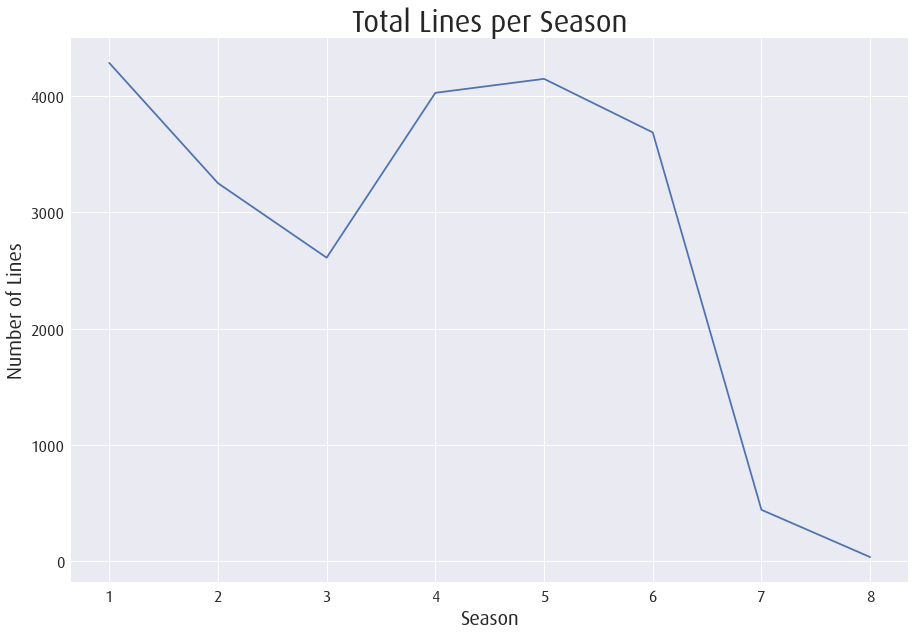

In [7]:
plt.figure(figsize = (15, 10)) #Set figure size
plt.plot(q0['Season'], q0['Season_Lines'], label = 'Total') #Setting plot
plt.title('Total Lines per Season', size = 30) #Set title of graph
plt.xlabel('Season', size = 20) #Set x label
plt.xticks(fontsize = 16) #Set tick size
plt.ylabel('Number of Lines', size = 20) #Set y label
plt.yticks(fontsize = 16) #Set tick size
plt.show() #Show graph

## Lines During Series

The following query explores the number of lines per character throughout the entires series.

In [8]:
q1 = pd.read_sql("""
SELECT Character, Count(Line) AS 'Spoken_Lines'
FROM DFforSQL
GROUP BY Character
ORDER BY Spoken_Lines DESC
;
""", conn) #Query to count number of lines per character throughout series

q1 #Print query

Character  Spoken_Lines
0       Ted          6058
1    Barney          4722
2  Marshall          4309
3     Robin          3806
4      Lily          3580

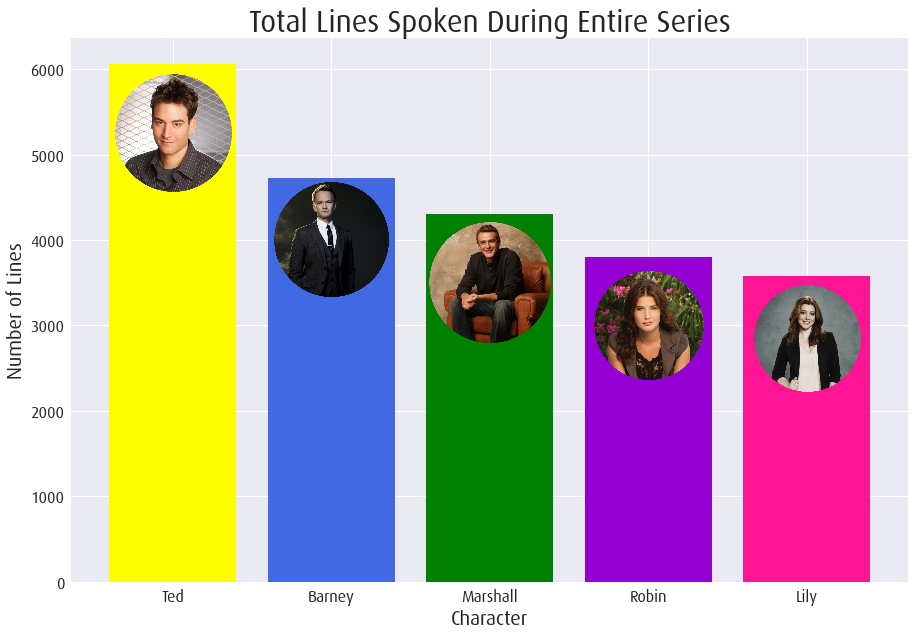

In [9]:
plt.figure(figsize = (15, 10)) #Set figure size
c = ['yellow', 'royalblue', 'green', 'darkviolet', 'deeppink'] #Setting bar colors
plt.bar(range(5), q1['Spoken_Lines'], color = c) #Set bar range
plt.xticks(range(5), q1['Character']) #Set x ticks
ax = plt.gca() #Set axis
# Ted
img = plt.imread('Characters/Ted.png') #Read ted image
im = OffsetImage(img, zoom = .18) #Set image zoom
im.image.axes = ax #set axis space
x_offset = -25 #offset by space
ab = AnnotationBbox(im, (.16, 5250), xybox = (x_offset, 0), frameon = False, xycoords = 'data', 
                   boxcoords = 'offset points', pad = 0) #place image in exact space
ax.add_artist(ab) #add image
# Barney
img = plt.imread('Characters/Barney.png') #Read barney image
im = OffsetImage(img, zoom = .2) #set image zoom
im.image.axes = ax #set axis space
x_offset = -25 #offset by space
ab = AnnotationBbox(im, (1.16, 4000), xybox = (x_offset, 0), frameon = False, xycoords = 'data', 
                   boxcoords = 'offset points', pad = 0) #place image in exact space
ax.add_artist(ab) #add image
# Marshall
img = plt.imread('Characters/Marshall.png') #read marshall image
im = OffsetImage(img, zoom = .18) #set image zoom
im.image.axes = ax #set axis space
x_offset = -25 #offset by space
ab = AnnotationBbox(im, (2.16, 3500), xybox = (x_offset, 0), frameon = False, xycoords = 'data', 
                   boxcoords = 'offset points', pad = 0) #place image in exact space
ax.add_artist(ab) #add image
# Robin
img = plt.imread('Characters/Robin.png') #read robin image
im = OffsetImage(img, zoom = .2) #set image zoom
im.image.axes = ax #set axis space
x_offset = -25 #offset by space
ab = AnnotationBbox(im, (3.16, 3000), xybox = (x_offset, 0), frameon = False, xycoords = 'data', 
                   boxcoords = 'offset points', pad = 0) #place image in exact space
ax.add_artist(ab) #add image
# Lily
img = plt.imread('Characters/Lily.png') #read lily image
im = OffsetImage(img, zoom = .2) #set image zoom
im.image.axes = ax #set axis space
x_offset = -25 #offset by space
ab = AnnotationBbox(im, (4.16, 2850), xybox = (x_offset, 0), frameon = False, xycoords = 'data', 
                   boxcoords = 'offset points', pad = 0) #place image in exact space
ax.add_artist(ab) #add image
plt.title('Total Lines Spoken During Entire Series', size = 30) #Set title of graph
plt.xlabel('Character', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Number of Lines', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting tick size and values
plt.show(); #Show graph

It makes sense that Ted would have the most lines; he is the main character so most of the storylines revolve around him. It also makes sense that Barney and Marshall follow behind, because they are his two best friends and are often involved in the shenanigans he gets into. I am surprised that Robin and Lily are significantly lower, especially Lily as she is in a lot of scenes, but that can be explained by a few things: improper transcribing of the scripts (goes back into why there are less lines from season 3 as well as 7 and 8), as well as screen time also doesn't mean more lines.


## Lines by Season

The following query explores the number of lines per character by each individual season.

In [10]:
q2 = pd.read_sql("""
SELECT Character, Season, COUNT(Line) AS 'Total_Lines'
FROM DFforSQL
WHERE Character IN ('Ted', 'Barney', 'Marshall', 'Robin', 'Lily')
GROUP BY Season, Character
;
""", conn) #query to count number of character lines by season

q2 #print query

Character Season  Total_Lines
0     Barney      1          747
1       Lily      1          733
2   Marshall      1          751
3      Robin      1          658
4        Ted      1         1393
5     Barney      2          621
6       Lily      2          523
7   Marshall      2          607
8      Robin      2          605
9        Ted      2          893
10    Barney      3          674
11      Lily      3          388
12  Marshall      3          435
13     Robin      3          399
14       Ted      3          713
15    Barney      4          938
16      Lily      4          567
17  Marshall      4          788
18     Robin      4          691
19       Ted      4         1041
20    Barney      5          845
21      Lily      5          665
22  Marshall      5          856
23     Robin      5          741
24       Ted      5         1038
25    Barney      6          811
26      Lily      6          631
27  Marshall      6          736
28     Robin      6          633
29       Ted      6          874
30    Barney      7           80
31      Lily      7           68
32  Marshall      7          125
33     Robin      7           76
34       Ted      7           94
35    Barney      8            6
36      Lily      8            5
37  Marshall      8           11
38     Robin      8            3
39       Ted      8           12

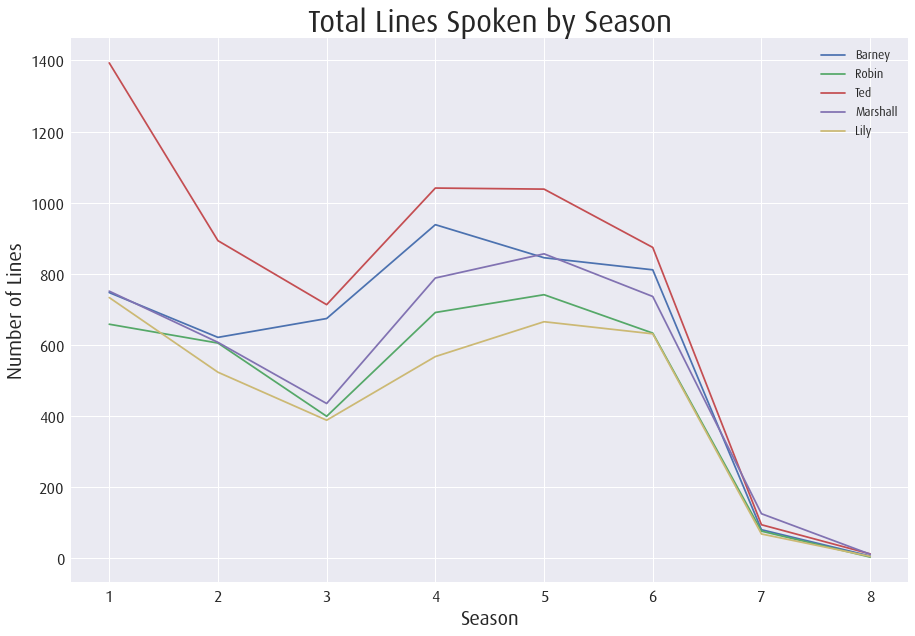

In [11]:
char_set = set(q2['Character']) #Turn individual characters into set

c = ['darkviolet', 'royalblue', 'deeppink', 'yellow', 'green'] #Setting line colors

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = q2.loc[q2['Character'] == character] #Grab characters
    plt.plot(selected_data['Season'], selected_data['Total_Lines'], label = character) #Plot lines
    
    
plt.title('Total Lines Spoken by Season', size = 30) #Set title of graph
plt.xlabel('Season', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Number of Lines', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'large')
plt.show()

As we look at the amount of lines spoken over each season, ignoring the dropoff in seasons 7 and 8 as well as keeping in mind the fact that transcribing did not properly capture every line from every character, we can see how some character arcs played out. Season 1 was all about introducing the characters, but specifically Ted, so it makes sense that he has the most lines as he had many scenes individually with other characters. You see a shift down from season 1 to season 2 with Lily's lines, and that makes sense with her arc as she left for San Francisco and wasn't around for a couple episodes in season 2, which explains why she would have less lines. Marshall's story arc grows as his career and marriage grows and flourishes as well, and you can see that through the seasons, especially season 5. Barney peaks at season 4, in the middle of his love affair with Robin and while he is trying to get Ted and Marshall to work for his company. This was an explanation to the silly little lines, but the fluctuations make sense.


## Most Spoken About

The following query explores which character was spoken about the most by other characters. First, nicknames were laid out for each character so that the number of mentions could be counted throughout the series. Then the nicknames with more than a couple mentions were graphed, so we can get an idea of how they refer to each other.

In [12]:
nicknames = [['Ted', 'Teddy Westside', 'T-Mose', 'Teddy Bear', 'Galactic President Superstar McAwesomeville'], 
            ['Marshall', 'Marsh ', 'Marshmallow', 'Big Fudge', 'Vanilla Thunder', 'Marsh Madness'], 
            ['Barney', 'The Barnacle'], 
            ['Robin', 'Robin Sparkles', 'RJ', 'Roland'], 
            ['Lily', 'Lilypad', 'Lori']] #listing nicknames for each character

In [13]:
all_lines = pd.read_sql("""
SELECT Line
FROM DFforSQL""", conn) #SQL query to get all lines

char_mention = [] #list to hold all character mention totals

for name_list in nicknames: #Loop for each character
    mention_counter = 0 #Keep track of each mention
    for name in name_list: #Loop for each nickname
        mentions = all_lines['Line'].str.count(name).sum() #sum of all nickname mentions
        mention_counter += mentions #add mentions to list
        char_mention.append([name_list[0], mention_counter]) #Append name and mention count

In [14]:
char_mention #print list of mentions

[['Ted', 1457],
 ['Ted', 1462],
 ['Ted', 1465],
 ['Ted', 1467],
 ['Ted', 1468],
 ['Marshall', 888],
 ['Marshall', 889],
 ['Marshall', 898],
 ['Marshall', 901],
 ['Marshall', 902],
 ['Marshall', 903],
 ['Barney', 962],
 ['Barney', 964],
 ['Robin', 868],
 ['Robin', 871],
 ['Robin', 872],
 ['Robin', 873],
 ['Lily', 909],
 ['Lily', 916],
 ['Lily', 921]]

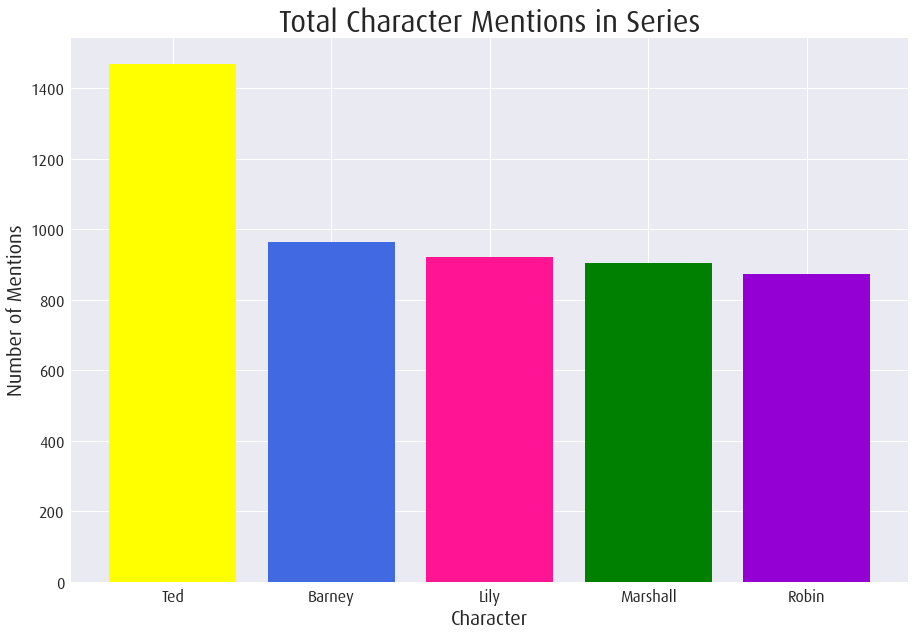

In [15]:
chars = ['Ted', 'Barney', 'Lily', 'Marshall', 'Robin'] #list of characters
mentions = [1468, 964, 921, 903, 873] #list of character mentions

plt.figure(figsize = (15, 10)) #Set figure size
c = ['yellow', 'royalblue', 'deeppink', 'green', 'darkviolet'] #Setting bar colors
plt.bar(chars, mentions, color = c) #Set graph
plt.title('Total Character Mentions in Series', size = 30) #Set title of graph
plt.xlabel('Character', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Number of Mentions', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting tick size and values
plt.show() #Show graph

The graph above is the total number of character mentions throughout the series; so anytime a character was mentioned by another one of the main characters, including themselves, either by nickname or name. It makes sense that Ted would be the most mentioned, as he is the main character. It also makes sense that they refer to Barney the second most as he does a lot of talk-worthy stuff and they worry about him as a friend. Lily, Marshall, and Robin do follow close behind, though.

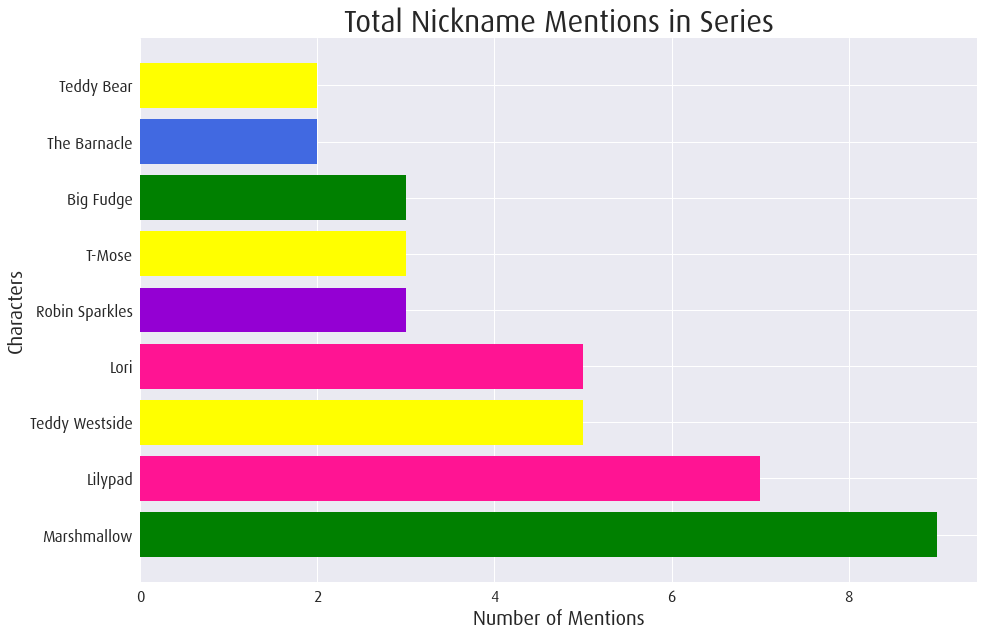

In [16]:
chars = ['Marshmallow', 'Lilypad', 'Teddy Westside', 'Lori', 'Robin Sparkles', 'T-Mose', 'Big Fudge', 
        'The Barnacle', 'Teddy Bear'] #list of nicknames
mentions = [9, 7, 5, 5, 3, 3, 3, 2, 2] #list of nickname mentions

plt.figure(figsize = (15, 10)) #Set figure size
c = ['green', 'deeppink', 'yellow', 'deeppink', 'darkviolet', 'yellow', 'green', 'royalblue', 'yellow'] #Setting bar colors
plt.barh(chars, mentions, color = c) #Set graph
plt.title('Total Nickname Mentions in Series', size = 30) #Set title of graph
plt.xlabel('Number of Mentions', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Characters', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting tick size and values
plt.show() #Show graph

Marshmallow and Lilypad are the two most mentioned nicknames; those are the petnames that Marshall and Lily refer to each other as. Teddy Westside is a nickname Ted uses for himself when he's trying to be "cool", but the gang just makes fun of him for it. The rest of the nicknames are canonical to the HIMYM universe; especially Robin Sparkles, Robin's name when she was a teen popstar in Canada, and Big Fudge, Marshall's nickname for himself. Looking at these numbers, I definitely know that the website did not transcribe the scripts properly, as all of these numbers should be much higher. I went back and checked for Season 2 Episode 7 specifically, as there should be numerous mentions of the nickname "Swarley", but when I went to check, it turns out the transcript of that episode is just a copy of the transcript of the previous episode. I'm guessing a lot of episodes are mislabeled and copied.


## Catchphrases and Largest Vocabulary

Next we'll get an idea of how many times certain catchphrases were mentioned, but I won't be looking at who said what and I also won't be graphing this due to the volume of missing transcripts. We'll also be taking a look at who has the largest/most diverse vocabulary.

In [17]:
df['Line'].str.contains('Lawyered').sum() + df['Line'].str.contains('lawyered').sum() #sum of lawyered mentions

10

The catchphrase "Lawyered" is mentioned 10 times.

In [18]:
df['Line'].str.contains('Canada').sum() #sum of canada mentions

54

The term "Canada" is mentioned 54 times; which makes sense as Robin is from Canada and they love to make fun of her for that and make jokes about it.

In [19]:
(df['Line'].str.contains('Suit up').sum() 
 + df['Line'].str.contains('suit up').sum() 
 + df['Line'].str.contains('SUIT UP').sum()) #sum of suit up mentions

11

The catchphrase "suit up" is mentioned 11 times.

In [20]:
df['Line'].str.contains('suit').sum() #sum of suit mentions

95

WOW, 95 mentions of the word suit!

In [21]:
df['Line'].str.contains('suits').sum() #sum of suits mentions

16

And suits is mentioned 16 times! Barney sure does love to wear them!

In [22]:
df['Line'].str.contains('high five').sum() + df['Line'].str.contains('High five').sum() #sum of high five mentions

7

The catchphrase "high five" is mentioned 7 times.

In [23]:
df['Line'].str.contains('legendary').sum() + df['Line'].str.contains('Legendary').sum() #sum of legendary mentions

16

The catchphrase "Legendary" is mentioned 16 times.

In [24]:
df['Line'].str.contains('wait for it').sum() + df['Line'].str.contains('Wait for it').sum() #sum of wfi mentions

16

The catchphrase "wait for it" is mentioned 16 times.

In [25]:
q3 = pd.read_sql("""
SELECT Character, Line
FROM DFforSQL
WHERE Character IN ('Ted', 'Barney', 'Marshall', 'Robin', 'Lily')
;
""", conn) #query for all lines by each character

q3 #print query

Character                                               Line
0      Marshall                                 Will you marry me.
1           Ted  Yes, perfect! And then you're engaged, you pop...
2      Marshall  Got it. Thanks for helping me plan this out, Ted.
3           Ted  Dude, are you kidding? It's you and Lily! I've...
4      Marshall           yeah, sorry. We thought you were asleep.
...         ...                                                ...
22470  Marshall                                 It is so much fun.
22471  Marshall                               I love crushed nuts.
22472    Barney  "I'm probably saying some political stuff righ...
22473    Barney                Whoa. Is there going to be a fight?
22474       Ted                                     They're happy.

[22475 rows x 2 columns]

In [26]:
q3.Line = q3.Line.apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x)) #Removing all non alphabet characters

q3.Line = q3.Line.str.lower() #Making everything lowercase

q3 #Checking q3

Character                                               Line
0      Marshall                                  will you marry me
1           Ted  yes perfect and then youre engaged you pop the...
2      Marshall     got it thanks for helping me plan this out ted
3           Ted  dude are you kidding its you and lily ive been...
4      Marshall              yeah sorry we thought you were asleep
...         ...                                                ...
22470  Marshall                                  it is so much fun
22471  Marshall                                i love crushed nuts
22472    Barney  im probably saying some political stuff right ...
22473    Barney                  whoa is there going to be a fight
22474       Ted                                       theyre happy

[22475 rows x 2 columns]

In [27]:
from collections import Counter
tedwords = Counter()
marshwords = Counter()
barnwords = Counter()
robwords = Counter()
lilwords = Counter()


q3[q3['Character'] == 'Ted'].Line.str.lower().str.split().apply(tedwords.update)
q3[q3['Character'] == 'Marshall'].Line.str.lower().str.split().apply(marshwords.update)
q3[q3['Character'] == 'Barney'].Line.str.lower().str.split().apply(barnwords.update)
q3[q3['Character'] == 'Robin'].Line.str.lower().str.split().apply(robwords.update)
q3[q3['Character'] == 'Lily'].Line.str.lower().str.split().apply(lilwords.update)

display(len(tedwords))
display(len(marshwords))
display(len(barnwords))
display(len(robwords))
display(len(lilwords))

6853

5369

6622

4500

4237

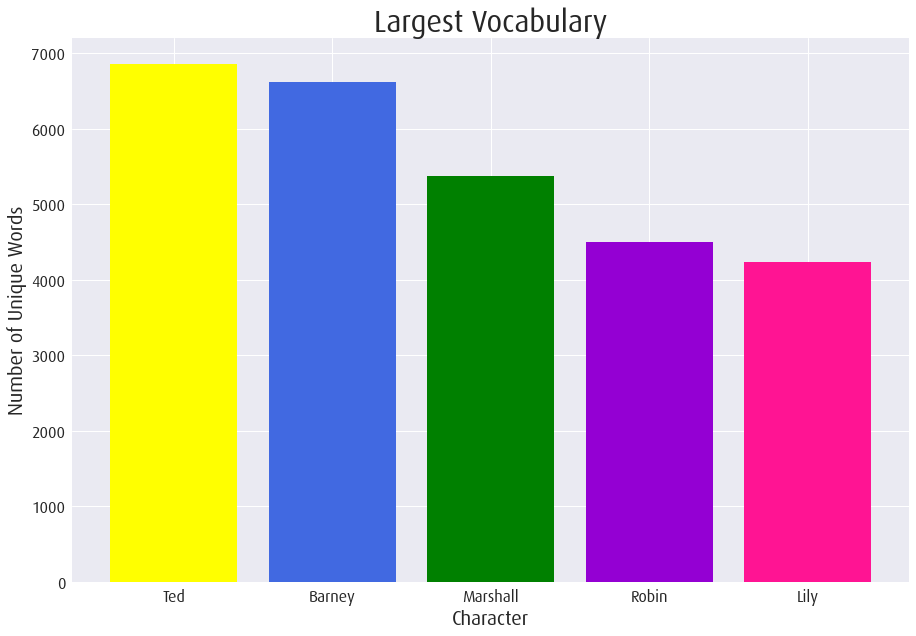

In [28]:
chars = ['Ted', 'Barney', 'Marshall', 'Robin', 'Lily'] #list of character names
mentions = [6853, 6622, 5369, 4500, 4237] #number of unique words each character spoke

plt.figure(figsize = (15, 10)) #Set figure size
c = ['yellow', 'royalblue', 'green', 'darkviolet', 'deeppink'] #Setting bar colors
plt.bar(chars, mentions, color = c) #Set graph
plt.title('Largest Vocabulary', size = 30) #Set title of graph
plt.xlabel('Character', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Number of Unique Words', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting tick size and values
plt.show() #Show graph

I might come back and remake this graph with their most used words placed on their bars. We'll see. Let's keep going!

## Frequency Distributions, WordClouds, Ngrams, and Mutual Information Scores

Next we'll be looking at a few different word exploration devices: frequency distributions to see how often the most common terms appear per character, wordclouds to visualize each character's most common terms, ngrams to look at the most common two through five word phrases per character, and mutual information scores, which is the score of an association between two tokens that a character spoke. All of these explorations will give us more information about the differences between each character's lines. Following this we'll take a look at sentiment.

### Setting Everything Up

In the following cells I set up my character dataframes and token lists and take a look at the total number of tokens in the corpus and per character. This is to get a general idea of the spread before I take the deep dive.

In [29]:
q3['Tokens'] = q3.Line.apply(lambda x: remstopandtok(x)) #Applying function to build new column

q3.head() #Reviewing df to make sure column was added

Character                                               Line  \
0  Marshall                                  will you marry me   
1       Ted  yes perfect and then youre engaged you pop the...   
2  Marshall     got it thanks for helping me plan this out ted   
3       Ted  dude are you kidding its you and lily ive been...   
4  Marshall              yeah sorry we thought you were asleep   

                                              Tokens  
0                                            [marry]  
1  [perfect, engaged, pop, champagne, drink, toas...  
2                       [thanks, helping, plan, ted]  
3  [dude, kidding, lily, big, moments, lily, nigh...  
4                           [sorry, thought, asleep]

In [30]:
Ted_DF = q3['Tokens'].loc[q3['Character'] == 'Ted'] #New DF of only tokens spoken by Ted
Marshall_DF = q3['Tokens'].loc[q3['Character'] == 'Marshall'] #New DF of only tokens spoken by Marshall
Barney_DF = q3['Tokens'].loc[q3['Character'] == 'Barney'] #New DF of only tokens spoken by Barney
Robin_DF = q3['Tokens'].loc[q3['Character'] == 'Robin'] #New DF of only tokens spoken by Robin
Lily_DF = q3['Tokens'].loc[q3['Character'] == 'Lily'] #New DF of only tokens spoken by Lily

tokens = [] #Instantiating total token list
ted_tokens = [] #Instantiation ted token list
marshall_tokens = [] #Instantiation marshall token list
barney_tokens = [] #Instantiation barney token list
robin_tokens = [] #Instantiation robin token list
lily_tokens = [] #Instantiation lily token list

for row in q3['Tokens']:
    tokens.extend(row) #Populating token list from df
for row in Ted_DF:
    ted_tokens.extend(row) #Populating token list from df
for row in Marshall_DF:
    marshall_tokens.extend(row) #Populating token list from df
for row in Barney_DF:
    barney_tokens.extend(row) #Populating token list from df
for row in Robin_DF:
    robin_tokens.extend(row) #Populating token list from df
for row in Lily_DF:
    lily_tokens.extend(row) #Populating token list from df

print(f'Total Corpus Tokens: {len(tokens)}') #Print total number of tokens
print(f'Number of Ted Tokens: {len(ted_tokens)}') #Print number of ted tokens
print(f'Number of Marshall Tokens: {len(marshall_tokens)}') #Print number of marshall tokens
print(f'Number of Barney Tokens: {len(barney_tokens)}') #Print number of barney tokens
print(f'Number of Robin Tokens: {len(robin_tokens)}') #Print number of robin tokens
print(f'Number of Lily Tokens: {len(lily_tokens)}') #Print number of lily tokens

Total Corpus Tokens: 121011
Number of Ted Tokens: 34459
Number of Marshall Tokens: 22895
Number of Barney Tokens: 28645
Number of Robin Tokens: 17962
Number of Lily Tokens: 17050


### Frequency Distributions

In [31]:
Corpus_FreqDist = FreqDist(tokens) #Instantiating corpus freqdist
Ted_FreqDist = FreqDist(ted_tokens) #Instantiating ted freqdist
Marshall_FreqDist = FreqDist(marshall_tokens) #Instantiating marshall freqdist
Barney_FreqDist = FreqDist(barney_tokens) #Instantiating barney freqdist
Robin_FreqDist = FreqDist(robin_tokens) #Instantiating robin freqdist
Lily_FreqDist = FreqDist(lily_tokens) #Instantiating lily freqdist

print('Top 25 Used Terms in Corpus:') #Printing title for corpus results
print(Corpus_FreqDist.most_common(25)) #Printing 25 most common corpus tokens
print('') #Printing space
print("Top 25 Used Terms in Ted's Lines:") #Printing title for ted's results
print(Ted_FreqDist.most_common(25)) #Printing 25 most common ted tokens
print('') #Printing space
print("Top 25 Used Terms in Marshall's Lines:") #Printing title for marshall's results
print(Marshall_FreqDist.most_common(25)) #Printing 25 most common marshall tokens
print('') #Printing space
print("Top 25 Used Terms in Barney's Lines:") #Printing title for barney's results
print(Barney_FreqDist.most_common(25)) #Printing 25 most common barney tokens
print('') #Printing space
print("Top 25 Used Terms in Robin's Lines:") #Printing title for robin's results
print(Robin_FreqDist.most_common(25)) #Printing 25 most common robin tokens
print('') #Printing space
print("Top 25 Used Terms in Lily's Lines:") #Printing title for lily's results
print(Lily_FreqDist.most_common(25)) #Printing 25 most common lily tokens

Top 25 Used Terms in Corpus:
[('know', 1740), ('ted', 1226), ('right', 1010), ('one', 912), ('want', 860), ('really', 808), ('lily', 771), ('barney', 769), ('think', 749), ('going', 737), ('robin', 718), ('marshall', 706), ('hey', 685), ('good', 673), ('guys', 631), ('look', 614), ('see', 591), ('say', 573), ('love', 570), ('come', 569), ('time', 555), ('tell', 480), ('great', 478), ('sorry', 463), ('never', 458)]

Top 25 Used Terms in Ted's Lines:
[('know', 484), ('right', 331), ('one', 264), ('really', 253), ('think', 251), ('want', 241), ('robin', 237), ('barney', 234), ('good', 219), ('hey', 215), ('lily', 213), ('going', 211), ('marshall', 208), ('look', 205), ('ted', 201), ('guys', 189), ('come', 187), ('see', 183), ('say', 169), ('time', 162), ('great', 160), ('uh', 151), ('love', 146), ('wait', 137), ('tell', 132)]

Top 25 Used Terms in Marshall's Lines:
[('know', 371), ('lily', 259), ('ted', 234), ('right', 204), ('think', 164), ('one', 148), ('want', 145), ('hey', 144), ('rea

Seeing a lot of similar terms, which means if we end up making a model that is predicting their lines it could be hard to distinguish between characters. Some common terms other than transitional words (like, yeah, go, want, etc.) are character names. This makes sense with what we saw earlier when we looked at total character mentions and nickname mentions. Let's move on to wordclouds so we can visualize these terms!

### WordClouds

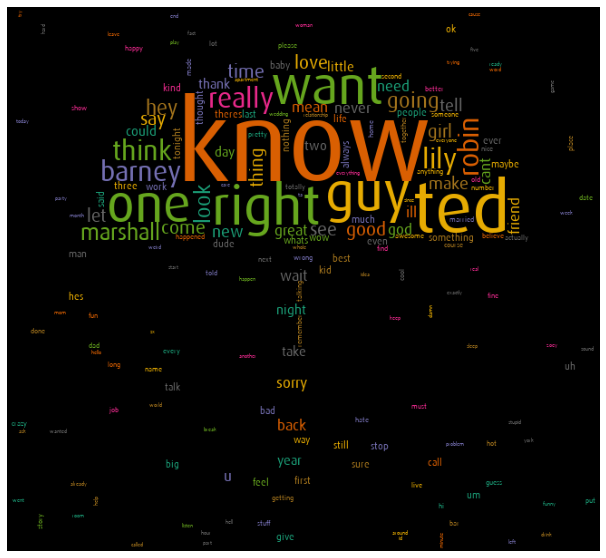

In [32]:
mask = np.array(Image.open('Images/umb2.png')) #Setting mask to image shape
make_wordcloud(tokens, 'Dark2', mask = mask) #Plotting word cloud of all tokens

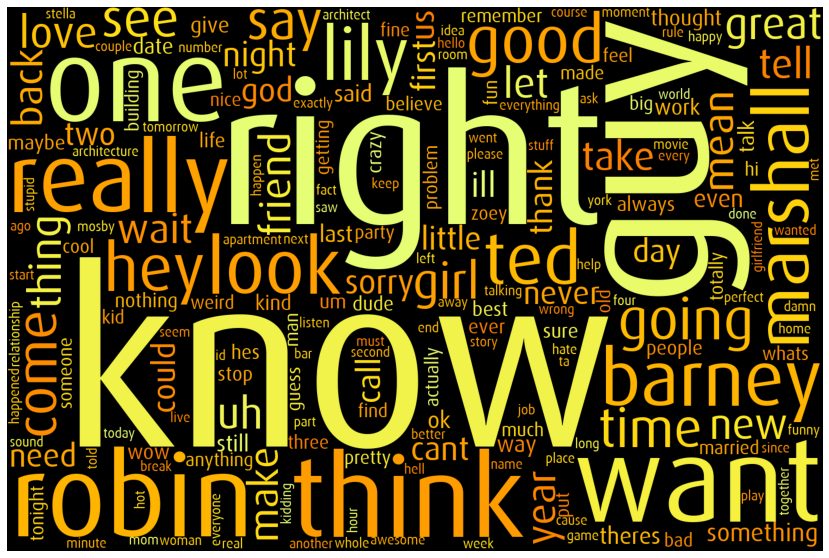

In [33]:
make_wordcloud(ted_tokens, 'Wistia', mask = None) #Plotting word cloud of ted tokens

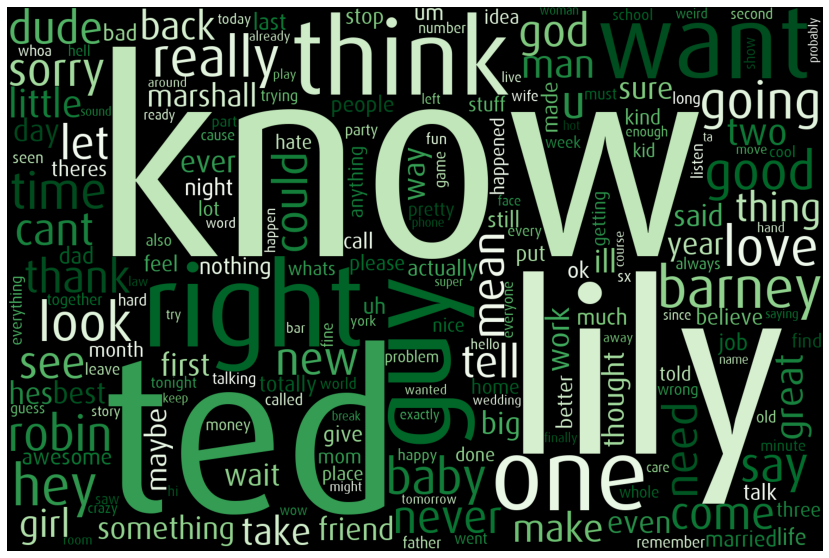

In [34]:
make_wordcloud(marshall_tokens, 'Greens', mask = None) #Plotting word cloud of marshall tokens

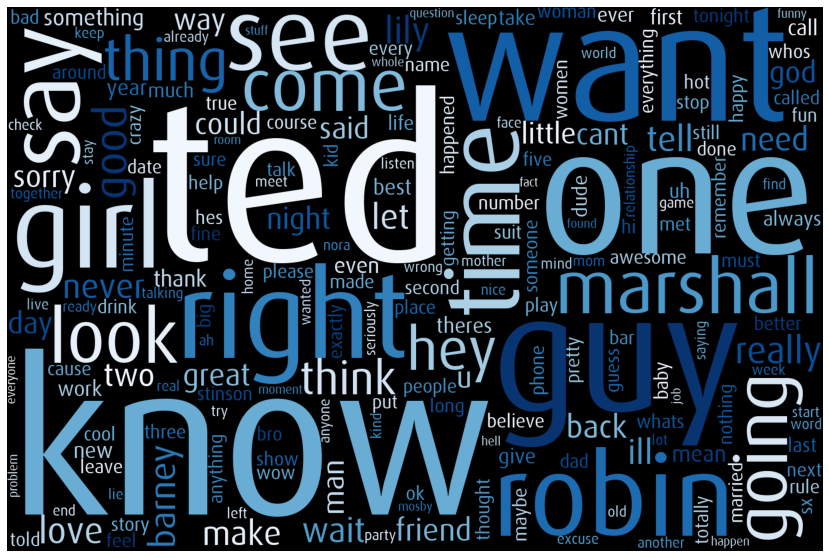

In [35]:
make_wordcloud(barney_tokens, 'Blues', mask = None) #Plotting word cloud of barney tokens

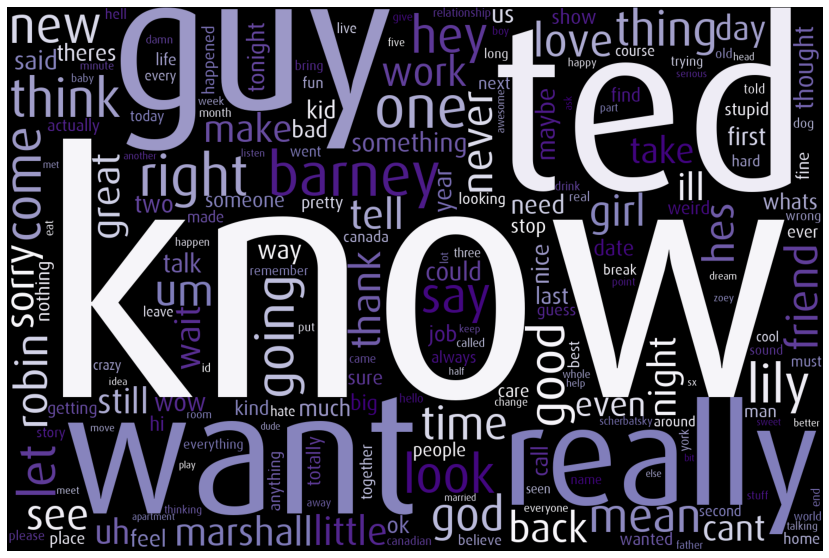

In [36]:
make_wordcloud(robin_tokens, 'Purples', mask = None) #Plotting word cloud of robin tokens

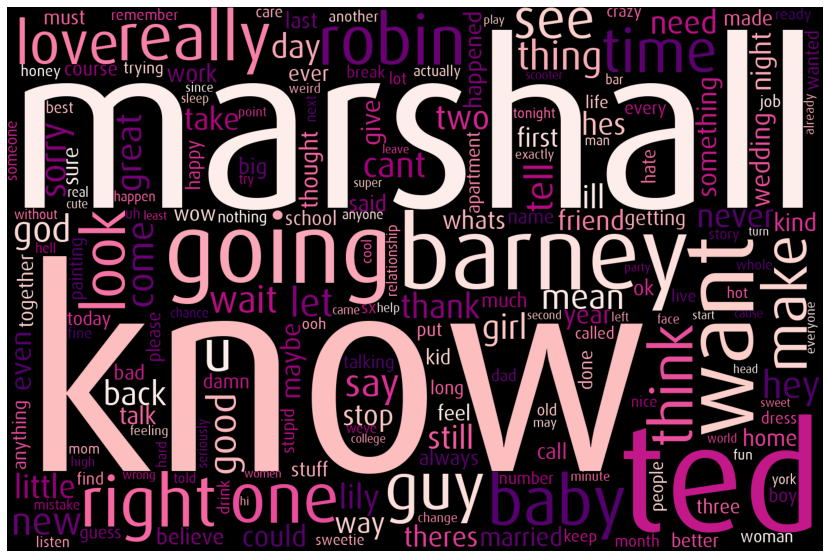

In [37]:
make_wordcloud(lily_tokens, 'RdPu', mask = None) #Plotting word cloud of lily tokens

Reviewing the wordclouds helps provide a little more clarity between the most used terms. Specific names are used more between specific characters. Lily and Marshall refer to each other more often than others, which makes sense since their storyline involves their relationship evolving into marriage. Unfortunately, I was hoping more of the most used words would be more important and provide more insight but there isn't much. An example would be the words "wedding" and "painting" on Lily's wordcloud, which make sense because she is an artist and got married in season 2, so those are two things she discusses more than once. Let's take a look at ngrams now to see if we can provide more clarity.

### Ngrams

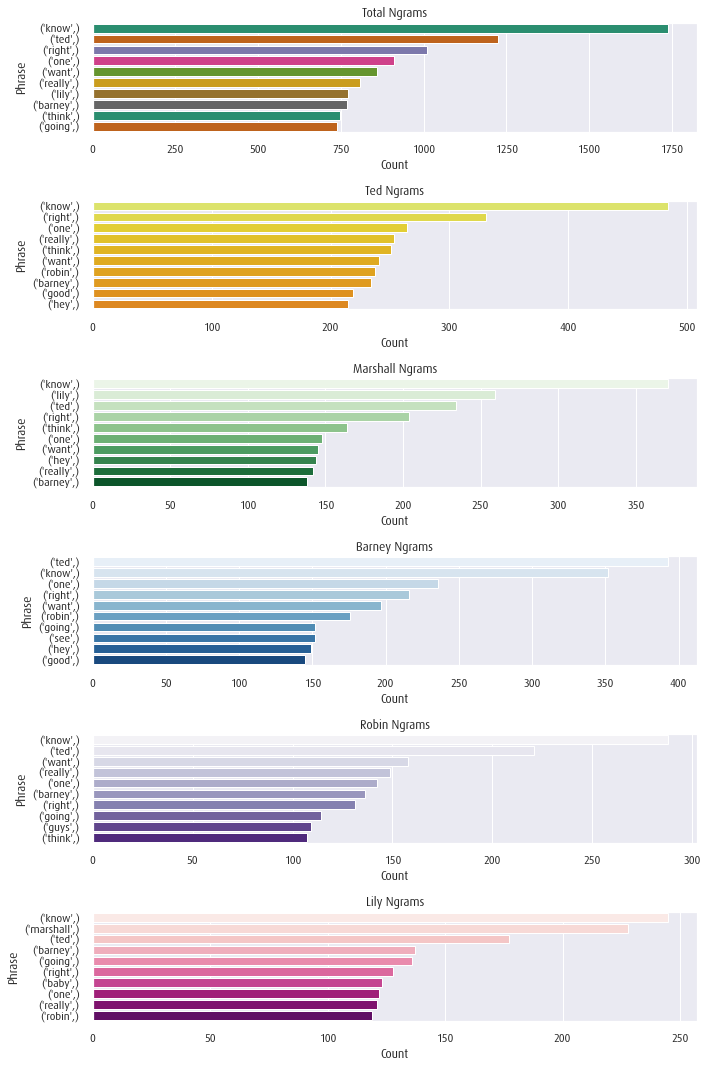

In [38]:
def make_ngram(i, tokens = tokens, ted_tokens = ted_tokens, marshall_tokens = marshall_tokens, 
              barney_tokens = barney_tokens, robin_tokens = robin_tokens, lily_tokens = lily_tokens): #define function
    """
    Function takes in a number that will be the amount of tokens in the phrase and
    displays the 10 most common phrases of that number of tokens for each token list.
    """
    
    n_gram_tot = (pd.Series(nltk.ngrams(tokens, i)).value_counts())[:10] #Setting up total ngrams
    n_gram_ted = (pd.Series(nltk.ngrams(ted_tokens, i)).value_counts())[:10] #Setting up ted ngrams
    n_gram_marshall = (pd.Series(nltk.ngrams(marshall_tokens, i)).value_counts())[:10] #Setting up marshall ngrams
    n_gram_barney = (pd.Series(nltk.ngrams(barney_tokens, i)).value_counts())[:10] #Setting up barney ngrams
    n_gram_robin = (pd.Series(nltk.ngrams(robin_tokens, i)).value_counts())[:10] #Setting up robin ngrams
    n_gram_lily = (pd.Series(nltk.ngrams(lily_tokens, i)).value_counts())[:10] #Setting up lily ngrams
    
    n_gram_df_tot = pd.DataFrame(n_gram_tot) #Creating total ngram df
    n_gram_df_ted = pd.DataFrame(n_gram_ted) #Creating ted ngram df
    n_gram_df_marshall = pd.DataFrame(n_gram_marshall) #Creating marshall ngram df
    n_gram_df_barney = pd.DataFrame(n_gram_barney) #Creating barney ngram df
    n_gram_df_robin = pd.DataFrame(n_gram_robin) #Creating robin ngram df
    n_gram_df_lily = pd.DataFrame(n_gram_lily) #Creating lily ngram df
    
    n_gram_df_tot = n_gram_df_tot.reset_index() #Resetting index
    n_gram_df_ted = n_gram_df_ted.reset_index() #Resetting index
    n_gram_df_marshall = n_gram_df_marshall.reset_index() #Resetting index
    n_gram_df_barney = n_gram_df_barney.reset_index() #Resetting index
    n_gram_df_robin = n_gram_df_robin.reset_index() #Resetting index
    n_gram_df_lily = n_gram_df_lily.reset_index() #Resetting index
    
    n_gram_df_tot = n_gram_df_tot.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming total plot
    n_gram_df_ted = n_gram_df_ted.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming ted plot
    n_gram_df_marshall = n_gram_df_marshall.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming marshall plot
    n_gram_df_barney = n_gram_df_barney.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming barney plot
    n_gram_df_robin = n_gram_df_robin.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming robin plot
    n_gram_df_lily = n_gram_df_lily.rename(columns = {'index': 'Phrase', 0: 'Count'}) #Renaming lily plot
    
    with sns.axes_style('darkgrid'): #Setting seaborn to darkgrid style
        
        sns.set_theme(font = 'Dax')
        fig = plt.figure(figsize = (10, 15)) #Setting figsize
        ax1 = fig.add_subplot(611) #Stacking first figure
        ax2 = fig.add_subplot(612) #Stacking second figure
        ax3 = fig.add_subplot(613) #Stacking third figure
        ax4 = fig.add_subplot(614) #Stacking fourth figure
        ax5 = fig.add_subplot(615) #Stacking fifth figure
        ax6 = fig.add_subplot(616) #Stacking sixth figure
        
        sns.barplot(ax = ax1, x = 'Count', y = 'Phrase', data = n_gram_df_tot, 
                    palette = 'Dark2').set(title = 'Total Ngrams') #Assigning barplot to total ngrams
        sns.barplot(ax = ax2, x = 'Count', y = 'Phrase', data = n_gram_df_ted, 
                    palette = 'Wistia').set(title = 'Ted Ngrams') #Assigning barplot to ted ngrams
        sns.barplot(ax = ax3, x = 'Count', y = 'Phrase', data = n_gram_df_marshall, 
                    palette = 'Greens').set(title = 'Marshall Ngrams') #Assigning barplot to marshall ngrams
        sns.barplot(ax = ax4, x = 'Count', y = 'Phrase', data = n_gram_df_barney, 
                    palette = 'Blues').set(title = 'Barney Ngrams') #Assigning barplot to barney ngrams
        sns.barplot(ax = ax5, x = 'Count', y = 'Phrase', data = n_gram_df_robin, 
                    palette = 'Purples').set(title = 'Robin Ngrams') #Assigning barplot to robin ngrams
        sns.barplot(ax = ax6, x = 'Count', y = 'Phrase', data = n_gram_df_lily, 
                    palette = 'RdPu').set(title = 'Lily Ngrams') #Assigning barplot to lily ngrams
    
    plt.tight_layout() #Make plot layouts tight

make_ngram(1) #Plot 1 word ngrams

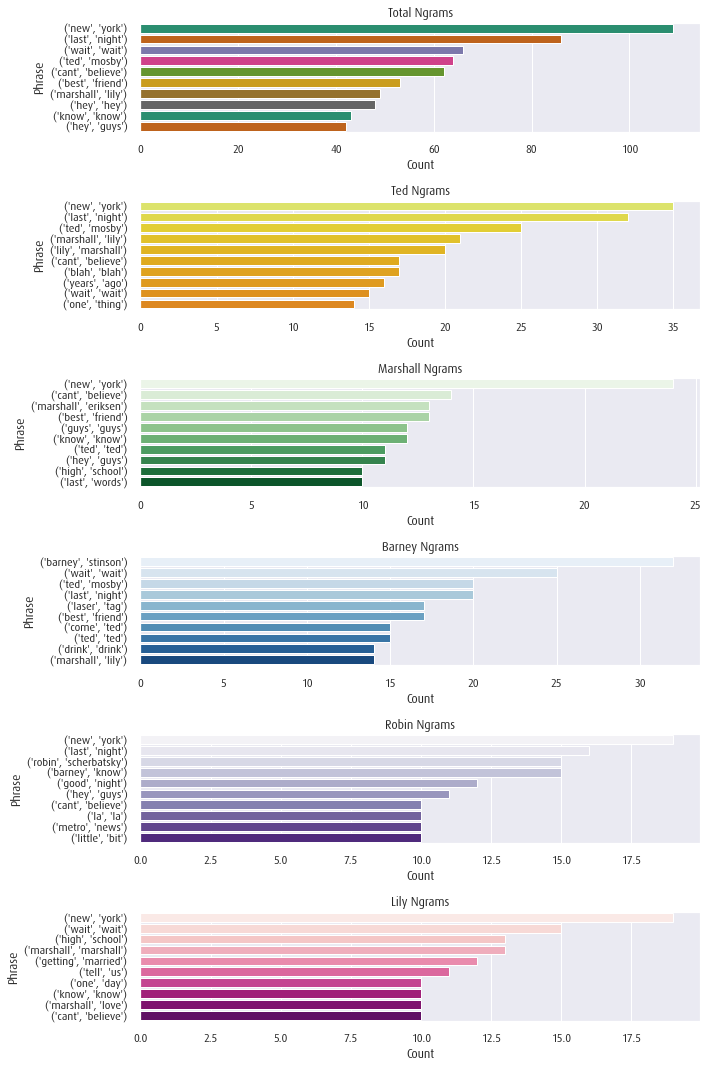

In [39]:
make_ngram(2) #Plot 2 word ngrams

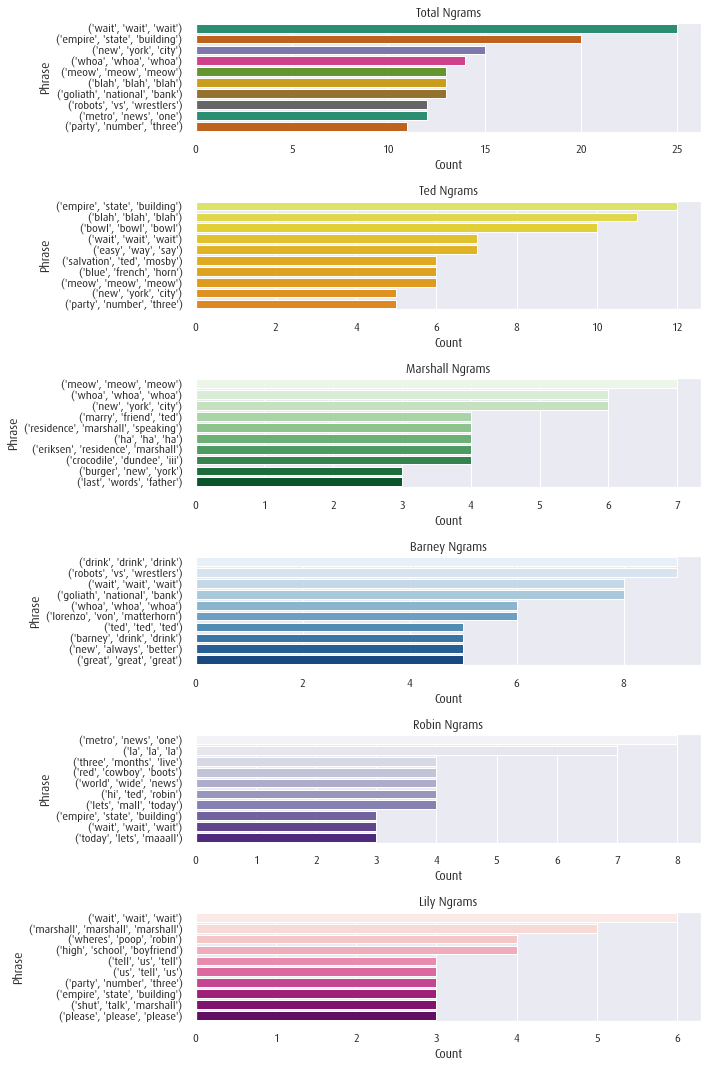

In [40]:
make_ngram(3) #Plot 3 word ngrams

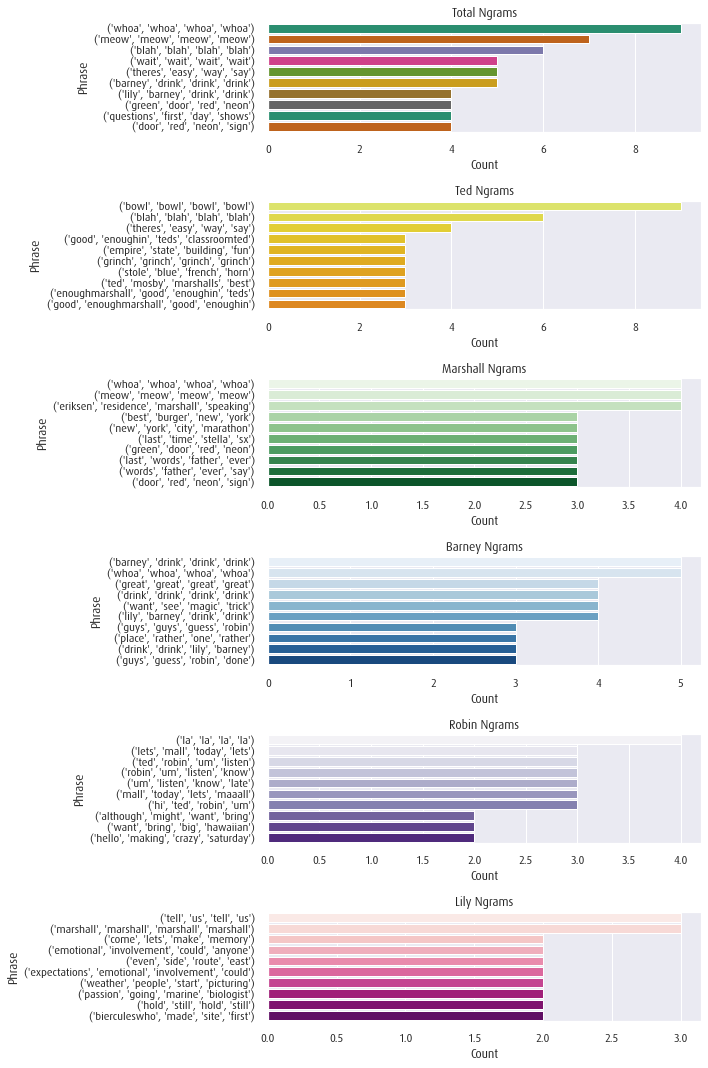

In [41]:
make_ngram(4) #Plot 4 word ngrams

We're seeing some differences here as our phrases grow by the number of words. Three word ngrams give us the biggest differences between characters, and I'm seeing memorable lines, as well as repetitive lines.

### Mutual Information Scores

In [42]:
calc_bigram(tokens, 25) #Looking at bigrams of all tokens

[(('laser', 'tag'), 11.974330255048413),
 (('high', 'school'), 9.657520493561858),
 (('whoa', 'whoa'), 8.744000014287323),
 (('new', 'york'), 8.190972044261477),
 (('new', 'jersey'), 8.182836926763796),
 (('years', 'ago'), 7.59680983419773),
 (('big', 'deal'), 7.569629107813817),
 (('three', 'days'), 7.564939318910712),
 (('three', 'months'), 7.233942322580058),
 (('little', 'bit'), 7.184677334724267),
 (('best', 'friend'), 7.0637267426468),
 (('barney', 'stinson'), 6.908896591362396),
 (('last', 'night'), 6.741974038418469),
 (('robin', 'scherbatsky'), 6.712440461974998),
 (('getting', 'married'), 6.648241207339343),
 (('cant', 'believe'), 6.490177680306235),
 (('ted', 'mosby'), 6.0103255622641285),
 (('whole', 'thing'), 6.001048601290519),
 (('best', 'friends'), 5.954542090276263),
 (('wait', 'wait'), 5.282438309336101),
 (('thank', 'god'), 5.172201095776476),
 (('every', 'time'), 5.034246199337019),
 (('last', 'time'), 4.699086662141916),
 (('ill', 'tell'), 4.204163930285279),
 (('w

In [43]:
calc_bigram(ted_tokens, 10) #Looking at bigrams of ted tokens

[(('empire', 'state'), 11.072593214717239),
 (('bowl', 'bowl'), 10.357099150853857),
 (('jen', 'coulin'), 10.23464997282621),
 (('blah', 'blah'), 10.112932143853554),
 (('state', 'building'), 9.102966863760757),
 (('big', 'deal'), 8.165702619108721),
 (('new', 'jersey'), 8.083908527945072),
 (('new', 'york'), 7.965264031446454),
 (('party', 'number'), 7.674342836184739),
 (('years', 'ago'), 7.5857581931541915),
 (('best', 'friend'), 7.379106257217913),
 (('ge', 'ted'), 7.3060643061183725),
 (('little', 'bit'), 7.050225401688781),
 (('last', 'night'), 6.6699808112106),
 (('ted', 'mosby'), 6.639132958610938),
 (('cant', 'believe'), 6.444522992440996),
 (('best', 'friends'), 6.020652286305438),
 (('plus', 'one'), 5.843774524221358),
 (('wait', 'wait'), 4.783419644404702),
 (('ill', 'tell'), 4.694298358805346),
 (('one', 'thing'), 4.05419430389173),
 (('marshall', 'lily'), 4.029761299129065),
 (('lily', 'marshall'), 3.959371971237667),
 (('guys', 'guys'), 3.4075399849123915),
 (('hey', 'gu

In [44]:
calc_bigram(marshall_tokens, 10) #Looking at bigrams of marshall tokens

[(('meow', 'meow'), 10.403793603166086),
 (('high', 'school'), 9.253926254065028),
 (('whoa', 'whoa'), 8.403793603166086),
 (('new', 'york'), 8.21595840386601),
 (('last', 'words'), 8.160816849673546),
 (('marshall', 'eriksen'), 7.657663853606934),
 (('best', 'friend'), 7.0798968542899825),
 (('cant', 'believe'), 6.5664389222085315),
 (('guys', 'guys'), 4.022971819225159),
 (('hey', 'guys'), 3.7498837487274432),
 (('really', 'really'), 3.505178800438907),
 (('hey', 'hey'), 3.4648230365636454),
 (('ted', 'ted'), 2.2014471240314),
 (('know', 'ted'), 1.399032943244066),
 (('know', 'know'), 0.9971566920404626)]

In [45]:
calc_bigram(barney_tokens, 10) #Looking at bigrams of barney tokens

[(('laser', 'tag'), 10.63607071587725),
 (('new', 'york'), 8.851799406932685),
 (('barney', 'stinson'), 7.494247402314601),
 (('drink', 'drink'), 7.268499955434175),
 (('last', 'night'), 6.923352667957719),
 (('best', 'friend'), 6.87178451571153),
 (('cant', 'believe'), 6.404340429961463),
 (('thank', 'god'), 6.193127220028519),
 (('ted', 'mosby'), 5.809098591807222),
 (('wait', 'wait'), 5.588377231968511),
 (('marshall', 'lily'), 4.398196867097587),
 (('met', 'ted'), 4.38025529300335),
 (('ill', 'tell'), 4.315746506692475),
 (('hey', 'hey'), 3.9526211771163915),
 (('one', 'thing'), 3.923352667957719),
 (('want', 'see'), 3.743371306477206),
 (('come', 'ted'), 2.9964687277089475),
 (('robin', 'know'), 2.2090605749323284),
 (('ted', 'ted'), 1.4761153084108685),
 (('ted', 'know'), 1.3131410971448112)]

In [46]:
calc_bigram(robin_tokens, 10) #Looking at bigrams of robin tokens

[(('la', 'la'), 10.053709035752465),
 (('metro', 'news'), 8.477308548534733),
 (('new', 'york'), 8.178464066760414),
 (('robin', 'scherbatsky'), 7.477308548534733),
 (('little', 'bit'), 7.3010364403265395),
 (('cant', 'believe'), 6.903841686651408),
 (('last', 'night'), 6.786146643981654),
 (('good', 'night'), 5.134069947401958),
 (('hey', 'guys'), 4.165696188255863),
 (('barney', 'know'), 2.782163130063152),
 (('ted', 'know'), 1.4967609112009068)]

In [47]:
calc_bigram(lily_tokens, 10) #Looking at bigrams of lily tokens

[(('high', 'school'), 8.730017840370103),
 (('new', 'york'), 7.828665428303015),
 (('getting', 'married'), 7.2161818648179565),
 (('cant', 'believe'), 6.1626663554909555),
 (('wait', 'wait'), 5.506737333415655),
 (('one', 'day'), 4.925112920066363),
 (('tell', 'us'), 4.881197617105146),
 (('marshall', 'love'), 3.007363388413488),
 (('marshall', 'marshall'), 2.092143808610503),
 (('know', 'know'), 1.5061363356811182)]

We're seeing some more specific differences here. These differences make sense in the context of the characters, as well as their relationships to each other. Taking a peak at the sentiment of each character next will certainly make the differences clearer.

## Sentiment Scores

For each line, a polarity and subjectivity score was calculated (done in the previous notebook). These scores represent the sentiment of the line (how positive or negative it was, measured from -1 to 1) and how subjective or objective the line was (0 being very objective and 1 being very subjective). Looking at these scores can tell us more about the character development over episodes and seasons, and can help inform what we want to model.

In [48]:
q4 = pd.read_sql("""
SELECT Season, Episode, Character, AVG(Polarity) as Avg_Polarity, AVG(Subjectivity) as Avg_Subjectivity
FROM DFforSQL
WHERE Character IN ('Ted', 'Marshall', 'Barney', 'Robin', 'Lily')
GROUP BY Season, Episode, Character
;
""", conn) #Query to grab average polarity and subjectivity by season and episode for each character

q4 #print query

Season Episode Character  Avg_Polarity  Avg_Subjectivity
0        1       1    Barney      0.172737          0.281741
1        1       1      Lily      0.074928          0.414778
2        1       1  Marshall      0.004677          0.228136
3        1       1     Robin      0.114525          0.225241
4        1       1       Ted      0.139807          0.261053
..     ...     ...       ...           ...               ...
689      8       7      Lily     -0.262500          0.350000
690      8       7  Marshall      0.000000          0.000000
691      8       7       Ted     -0.033333          0.066667
692      8       9     Robin     -0.140278          0.331944
693      8       9       Ted      0.000000          0.500000

[694 rows x 5 columns]

In [49]:
s1epsent = q4[q4['Season'] == '1'] #DF for season 1 sentiments by episode and character
s2epsent = q4[q4['Season'] == '2'] #DF for season 1 sentiments by episode and character
s3epsent = q4[q4['Season'] == '3'] #DF for season 1 sentiments by episode and character
s4epsent = q4[q4['Season'] == '4'] #DF for season 1 sentiments by episode and character
s5epsent = q4[q4['Season'] == '5'] #DF for season 1 sentiments by episode and character
s6epsent = q4[q4['Season'] == '6'] #DF for season 1 sentiments by episode and character
s7epsent = q4[q4['Season'] == '7'] #DF for season 1 sentiments by episode and character
s8epsent = q4[q4['Season'] == '8'] #DF for season 1 sentiments by episode and character

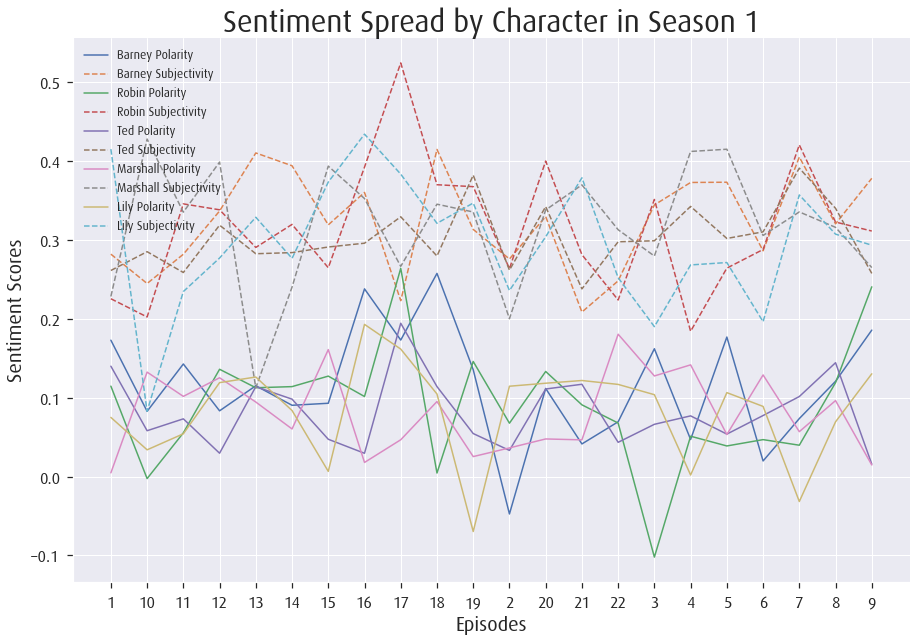

In [50]:
char_set = set(s1epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = s1epsent.loc[s1epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Sentiment Spread by Character in Season 1', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting tick size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16)
plt.legend(fontsize = 'medium')
plt.show()

Okay so looking at just season 1 is telling us a couple of things, first, we need to figure out how to reorganize the episodes, as they are in string format so they are organized by 1s then 2s instead of number order. We also probably don't need to put all of the characters on the same plot. Let's think about some character dynamics that would be interesting to look at:
* Marshall and Lily: They break up at the end of season 1 and get back together throughout season 2, so maybe creating a total season 1-2 sentiment chart of just those two characters would be interesting to look at.
* Ted and Robin: Season 1 is all about Ted chasing Robin, and season 2 is about them getting together, and season 3 is following their breakup, so perhaps looking at the sentiment changes between them across those three seasons would be interesting.
* Barney and Robin: Season 3-5 we start to see the back and forth between Robin and Barney, so a graph looking at their sentiment could be interesting as well.

Let's take a peek at these three, as well as keeping in mind reorganizing the episodes so they're in order.

### Marshall and Lily Sentiment Spread

In [51]:
q5 = pd.read_sql("""
SELECT Season, Episode, Character, AVG(Polarity) as Avg_Polarity, AVG(Subjectivity) as Avg_Subjectivity
FROM DFforSQL
WHERE Character IN ('Marshall', 'Lily')
GROUP BY Season, Episode, Character
;
""", conn) #query to grab polarity and subjectivity of marshall and lily

q5 #print query

Season Episode Character  Avg_Polarity  Avg_Subjectivity
0        1       1      Lily      0.074928          0.414778
1        1       1  Marshall      0.004677          0.228136
2        1      10      Lily      0.033862          0.082738
3        1      10  Marshall      0.132308          0.427561
4        1      11      Lily      0.054159          0.234360
..     ...     ...       ...           ...               ...
273      8      18  Marshall      0.000000          0.000000
274      8      24  Marshall      0.250000          0.275000
275      8       5  Marshall      0.000000          0.066667
276      8       7      Lily     -0.262500          0.350000
277      8       7  Marshall      0.000000          0.000000

[278 rows x 5 columns]

In [52]:
mls1epsent = q5[q5['Season'] == '1'] #DF for marsh/lil season 1 sentiments by episode
mls2epsent = q5[q5['Season'] == '2'] #DF for marsh/lil season 2 sentiments by episode

mls1epsent['SeEp'] = mls1epsent['Episode'].astype(int) #Change dtype to integer
mls2epsent['SeEp'] = mls2epsent['Episode'].astype(int) #Change dtype to integer

mls1epsent = mls1epsent.sort_values(by = ['SeEp'], ascending = True) #Sort in ascending order
mls2epsent = mls2epsent.sort_values(by = ['SeEp'], ascending = True) #Sort in ascending order

<ipython-input-52-d886f9aa524d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mls1epsent['SeEp'] = mls1epsent['Episode'].astype(int) #Change dtype to integer
<ipython-input-52-d886f9aa524d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mls2epsent['SeEp'] = mls2epsent['Episode'].astype(int) #Change dtype to integer


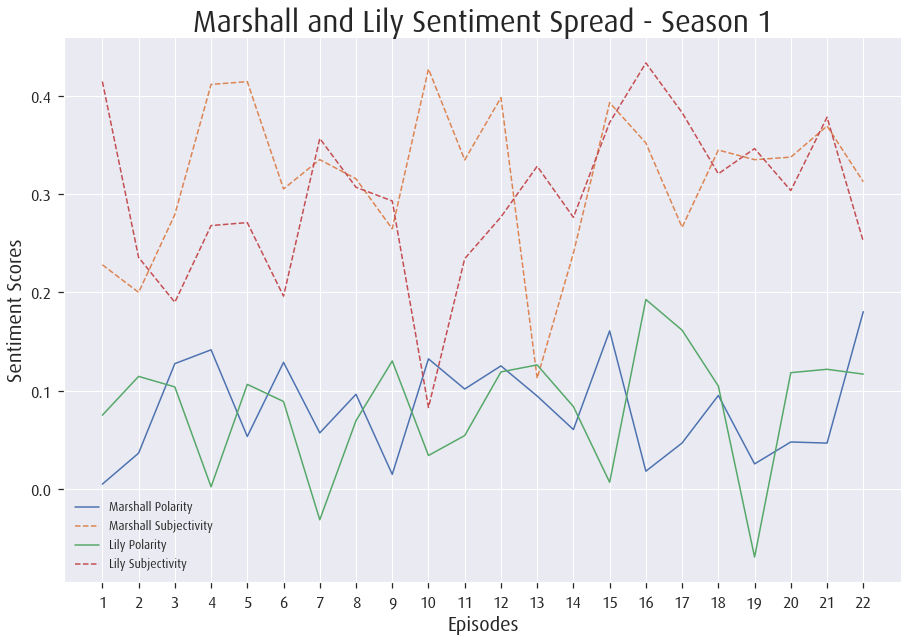

In [53]:
char_set = set(mls1epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = mls1epsent.loc[mls1epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Marshall and Lily Sentiment Spread - Season 1', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting font size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting font size
plt.legend(fontsize = 'medium') #Setting legend size
plt.show() #Show plot

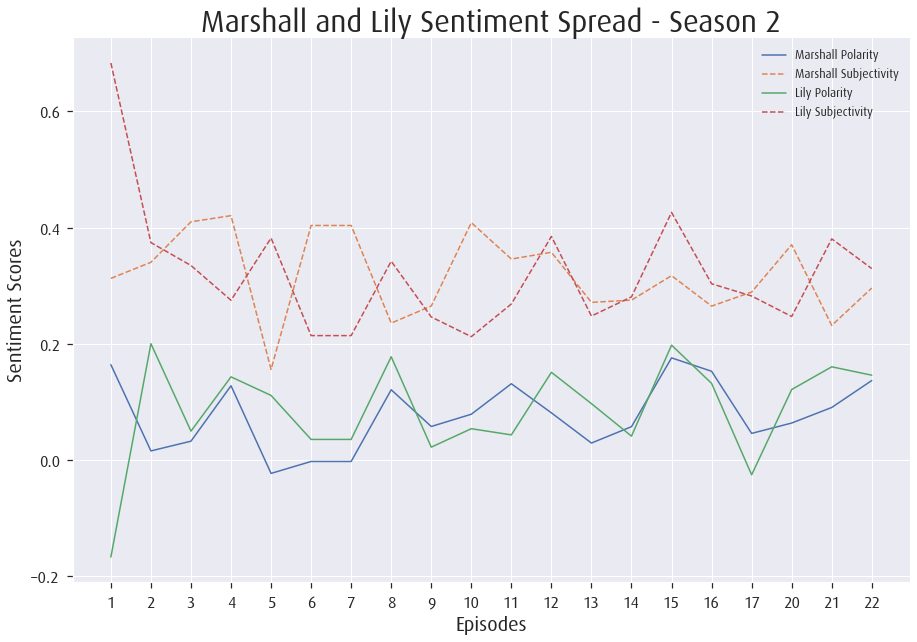

In [54]:
char_set = set(mls2epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = mls2epsent.loc[mls2epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Marshall and Lily Sentiment Spread - Season 2', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting font size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting font size
plt.legend(fontsize = 'medium') #Setting legend size
plt.show() #Show plot

### Ted and Robin Sentiment Spread

In [55]:
q6 = pd.read_sql("""
SELECT Season, Episode, Character, AVG(Polarity) as Avg_Polarity, AVG(Subjectivity) as Avg_Subjectivity
FROM DFforSQL
WHERE Character IN ('Ted', 'Robin')
GROUP BY Season, Episode, Character
;
""", conn) #query to get polarity and subjectivity of ted and robin by season

q6 #print query

Season Episode Character  Avg_Polarity  Avg_Subjectivity
0        1       1     Robin      0.114525          0.225241
1        1       1       Ted      0.139807          0.261053
2        1      10     Robin     -0.002587          0.202146
3        1      10       Ted      0.058059          0.284861
4        1      11     Robin      0.055362          0.345430
..     ...     ...       ...           ...               ...
273      8      19       Ted      0.000000          0.000000
274      8      24       Ted      0.800000          1.000000
275      8       7       Ted     -0.033333          0.066667
276      8       9     Robin     -0.140278          0.331944
277      8       9       Ted      0.000000          0.500000

[278 rows x 5 columns]

In [56]:
trs1epsent = q6[q6['Season'] == '1'] #DF for ted/robin season 1 sentiments by episode
trs2epsent = q6[q6['Season'] == '2'] #DF for ted/robin season 2 sentiments by episode
trs3epsent = q6[q6['Season'] == '3'] #DF for ted/robin season 3 sentiments by episode

trs1epsent['SeEp'] = trs1epsent['Episode'].astype(int) #change dtype to int
trs2epsent['SeEp'] = trs2epsent['Episode'].astype(int) #change dtype to int
trs3epsent['SeEp'] = trs3epsent['Episode'].astype(int) #change dtype to int

trs1epsent = trs1epsent.sort_values(by = ['SeEp'], ascending = True) #sort in ascending order
trs2epsent = trs2epsent.sort_values(by = ['SeEp'], ascending = True) #sort in ascending order
trs3epsent = trs3epsent.sort_values(by = ['SeEp'], ascending = True) #sort in ascending order

<ipython-input-56-bbe7bfb28b6b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trs1epsent['SeEp'] = trs1epsent['Episode'].astype(int) #change dtype to int
<ipython-input-56-bbe7bfb28b6b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trs2epsent['SeEp'] = trs2epsent['Episode'].astype(int) #change dtype to int
<ipython-input-56-bbe7bfb28b6b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

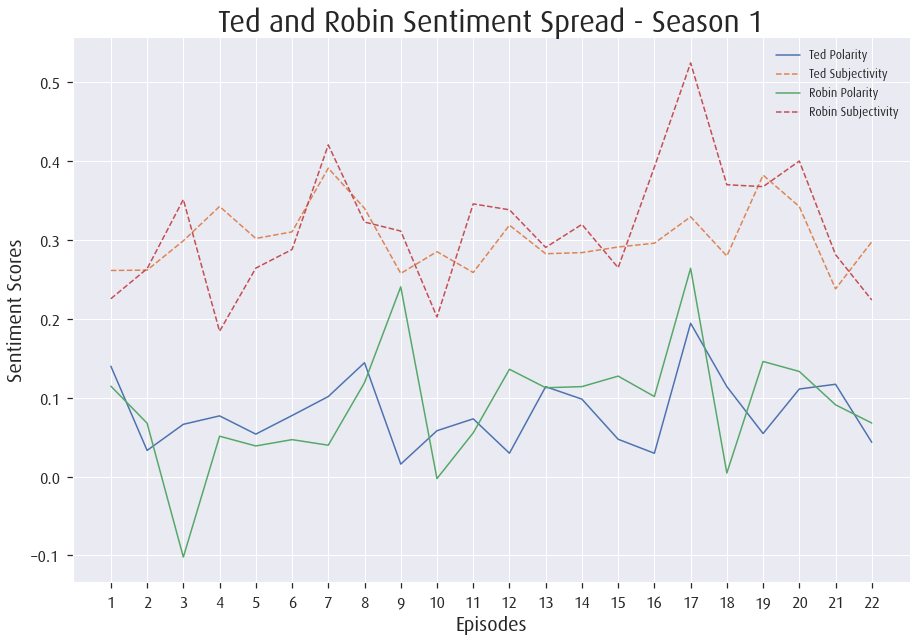

In [57]:
char_set = set(trs1epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = trs1epsent.loc[trs1epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Ted and Robin Sentiment Spread - Season 1', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting font size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting font size
plt.legend(fontsize = 'medium') #Setting legend size
plt.show() #Show plot

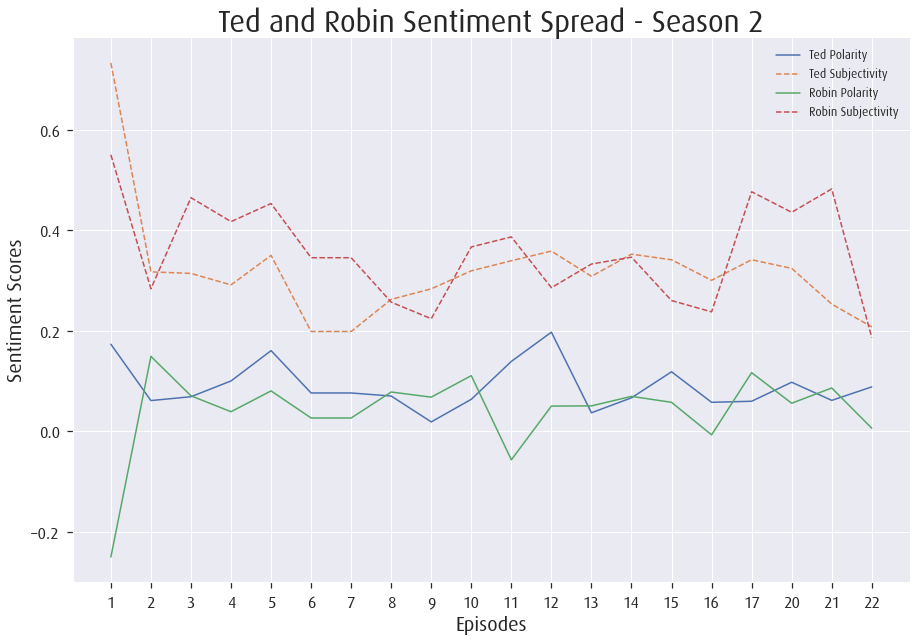

In [58]:
char_set = set(trs2epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = trs2epsent.loc[trs2epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Ted and Robin Sentiment Spread - Season 2', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting font size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting font size
plt.legend(fontsize = 'medium') #Setting legend size
plt.show() #Show plot

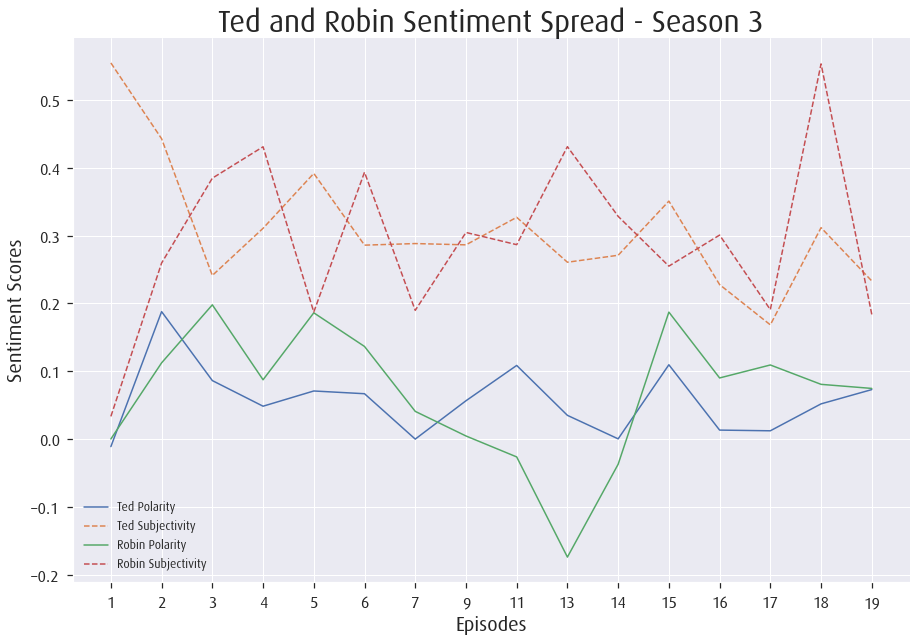

In [59]:
char_set = set(trs3epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = trs3epsent.loc[trs3epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Ted and Robin Sentiment Spread - Season 3', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting font size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting font size
plt.legend(fontsize = 'medium') #Setting legend size
plt.show() #Show plot

### Barney and Robin Sentiment Spread

In [60]:
q7 = pd.read_sql("""
SELECT Season, Episode, Character, AVG(Polarity) as Avg_Polarity, AVG(Subjectivity) as Avg_Subjectivity
FROM DFforSQL
WHERE Character IN ('Barney', 'Robin')
GROUP BY Season, Episode, Character
;
""", conn) #Query to find polarity and subjectivity of barney and robin by season and episode

q7 #print query

Season Episode Character  Avg_Polarity  Avg_Subjectivity
0        1       1    Barney      0.172737          0.281741
1        1       1     Robin      0.114525          0.225241
2        1      10    Barney      0.082633          0.244551
3        1      10     Robin     -0.002587          0.202146
4        1      11    Barney      0.142594          0.281614
..     ...     ...       ...           ...               ...
270      8      14     Robin      0.000000          0.000000
271      8      19    Barney      0.000000          0.000000
272      8      22    Barney      0.166667          0.600000
273      8      24    Barney      0.112500          0.209821
274      8       9     Robin     -0.140278          0.331944

[275 rows x 5 columns]

In [61]:
brs3epsent = q7[q7['Season'] == '3'] #DF for ted/robin season 1 sentiments by episode
brs4epsent = q7[q7['Season'] == '4'] #DF for ted/robin season 2 sentiments by episode
brs5epsent = q7[q7['Season'] == '5'] #DF for ted/robin season 3 sentiments by episode

brs3epsent['SeEp'] = brs3epsent['Episode'].astype(int) #Change dtype to int
brs4epsent['SeEp'] = brs4epsent['Episode'].astype(int) #Change dtype to int
brs5epsent['SeEp'] = brs5epsent['Episode'].astype(int) #Change dtype to int

brs3epsent = brs3epsent.sort_values(by = ['SeEp'], ascending = True) #Sort in ascending order
brs4epsent = brs4epsent.sort_values(by = ['SeEp'], ascending = True) #Sort in ascending order
brs5epsent = brs5epsent.sort_values(by = ['SeEp'], ascending = True) #Sort in ascending order

<ipython-input-61-878d4d61c194>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brs3epsent['SeEp'] = brs3epsent['Episode'].astype(int) #Change dtype to int
<ipython-input-61-878d4d61c194>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brs4epsent['SeEp'] = brs4epsent['Episode'].astype(int) #Change dtype to int
<ipython-input-61-878d4d61c194>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

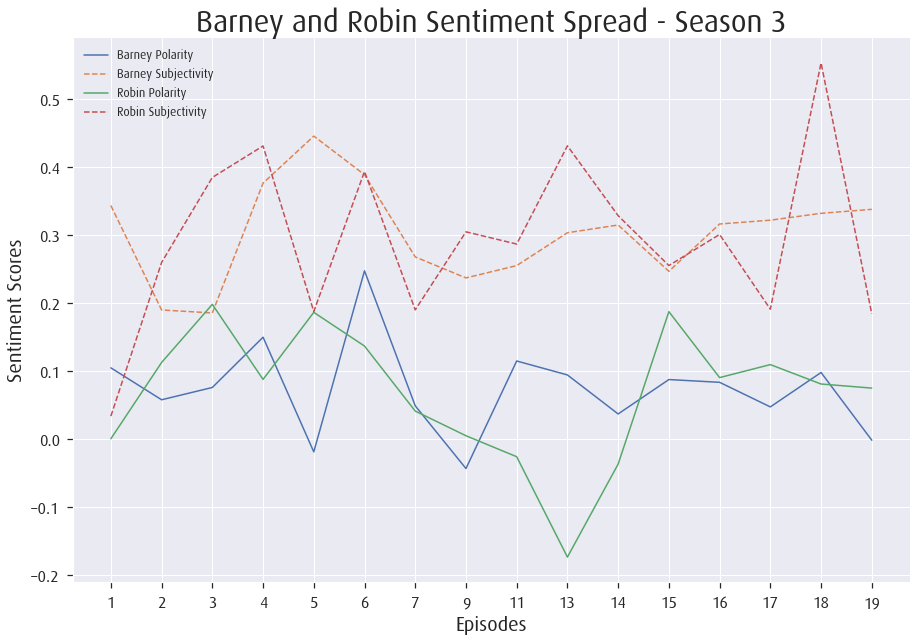

In [62]:
char_set = set(brs3epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = brs3epsent.loc[brs3epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Barney and Robin Sentiment Spread - Season 3', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting font size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting font size
plt.legend(fontsize = 'medium') #Setting legend size
plt.show() #Show plot

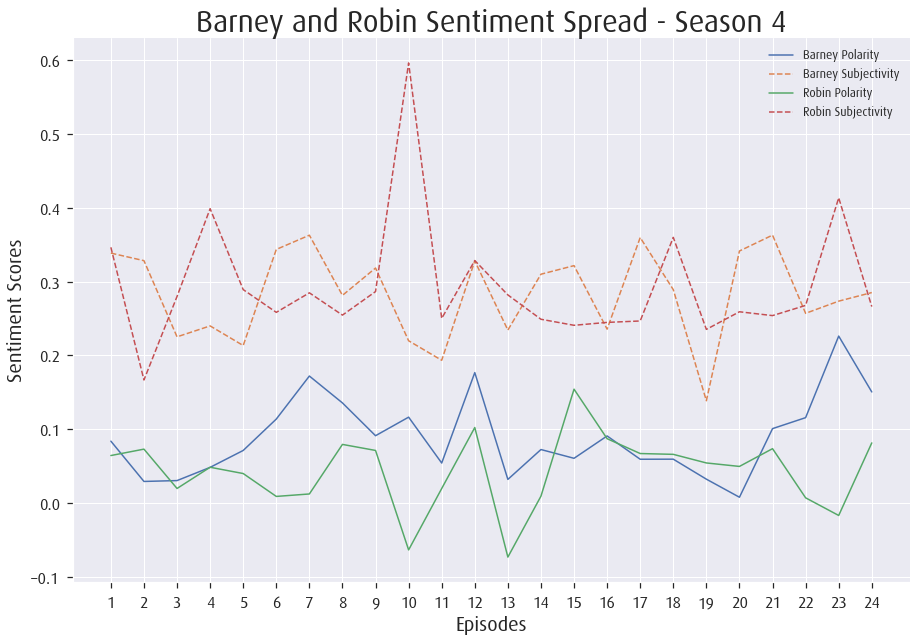

In [63]:
char_set = set(brs4epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = brs4epsent.loc[brs4epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Barney and Robin Sentiment Spread - Season 4', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting font size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting font size
plt.legend(fontsize = 'medium') #Setting legened size
plt.show() #Show plot

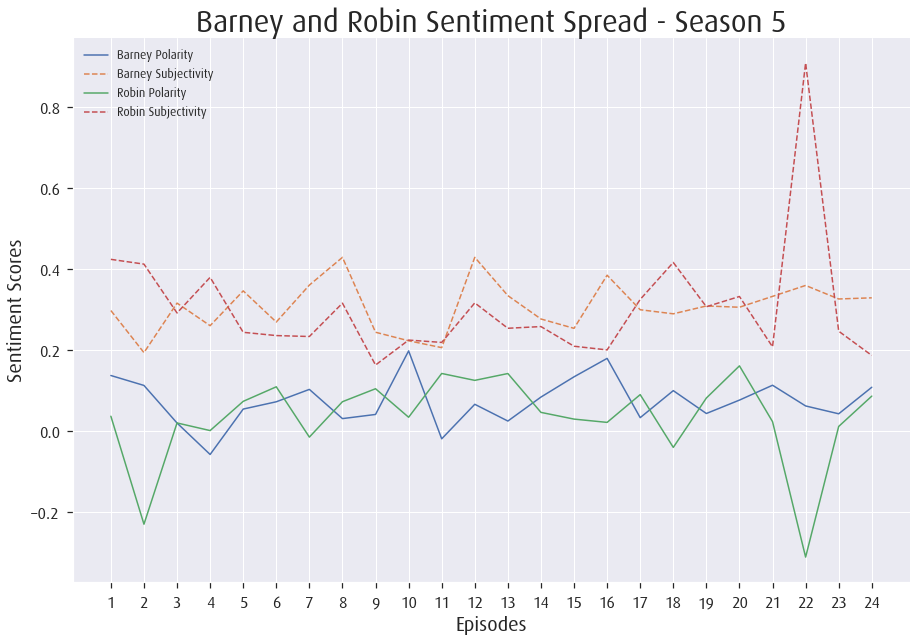

In [64]:
char_set = set(brs5epsent['Character']) #Turn individual characters into set

plt.figure(figsize = (15, 10)) #Set figure size
for character in char_set: #For loop to create graph
    selected_data = brs5epsent.loc[brs5epsent['Character'] == character] #Grab characters
    plt.plot(selected_data['Episode'], selected_data['Avg_Polarity'], label = f'{character} Polarity', 
            linestyle = '-') #Plot polarity line
    plt.plot(selected_data['Episode'], selected_data['Avg_Subjectivity'], label = f'{character} Subjectivity', 
            linestyle = '--') #Plot subjectivity line
    
    
plt.title('Barney and Robin Sentiment Spread - Season 5', size = 30) #Set title of graph
plt.xlabel('Episodes', size = 20) #Set x label
plt.xticks(fontsize = 16) #Setting font size
plt.ylabel('Sentiment Scores', size = 20) #Set y label
plt.yticks(fontsize = 16) #Setting font size
plt.legend(fontsize = 'medium') #Setting legend size
plt.show() #Show plot

Looking at Barney and Robin specifically gives a great example of how their storylines coincide with the spread of their subjectivity and polarity.

Now that we have sufficiently explored the data, we have enough information to inform us as we move through our modeling process. We'll finish off this notebook by preparing our text data to be modeled in the next notebook.

## Preparing to Model

For our data to be ready to model, we just need a list of tokens for each line, and the character name. Remember that we don't want to model seasons 7 or 8 because they are missing so many lines, so we also need to remove those from this query.

In [65]:
ModelDF = pd.read_sql("""
SELECT Character, Line
FROM DFforSQL
WHERE Character IN ('Ted', 'Barney', 'Marshall', 'Robin', 'Lily')
AND Season NOT IN (7, 8)
;
""", conn) #Query to find all lines for each character

ModelDF #print query

Character                                               Line
0      Marshall                                 Will you marry me.
1           Ted  Yes, perfect! And then you're engaged, you pop...
2      Marshall  Got it. Thanks for helping me plan this out, Ted.
3           Ted  Dude, are you kidding? It's you and Lily! I've...
4      Marshall           yeah, sorry. We thought you were asleep.
...         ...                                                ...
21990    Barney  I'll call you. You look beautiful, by the way....
21991    Barney                                Challenge accepted.
21992      Lily                   Best man? You're being summoned.
21993       Ted      Geez, what now?  I heard the groom needed me.
21994    Barney                     What do you think of this tie?

[21995 rows x 2 columns]

In [66]:
ModelDF.Line = ModelDF.Line.apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x)) #Removing all non alphabet characters

ModelDF.Line = ModelDF.Line.str.lower() #Making everything lowercase

ModelDF #Checking ModelDF

Character                                               Line
0      Marshall                                  will you marry me
1           Ted  yes perfect and then youre engaged you pop the...
2      Marshall     got it thanks for helping me plan this out ted
3           Ted  dude are you kidding its you and lily ive been...
4      Marshall              yeah sorry we thought you were asleep
...         ...                                                ...
21990    Barney  ill call you you look beautiful by the way and...
21991    Barney                                 challenge accepted
21992      Lily                      best man youre being summoned
21993       Ted         geez what now  i heard the groom needed me
21994    Barney                      what do you think of this tie

[21995 rows x 2 columns]

In [67]:
ModelDF['Tokens'] = ModelDF.Line.apply(lambda x: remstopandtok(x)) #Applying function to build new column

ModelDF.head() #Reviewing df to make sure column was added

Character                                               Line  \
0  Marshall                                  will you marry me   
1       Ted  yes perfect and then youre engaged you pop the...   
2  Marshall     got it thanks for helping me plan this out ted   
3       Ted  dude are you kidding its you and lily ive been...   
4  Marshall              yeah sorry we thought you were asleep   

                                              Tokens  
0                                            [marry]  
1  [perfect, engaged, pop, champagne, drink, toas...  
2                       [thanks, helping, plan, ted]  
3  [dude, kidding, lily, big, moments, lily, nigh...  
4                           [sorry, thought, asleep]

In [68]:
ModelDF.to_csv('ModelDF.csv', index = False) #Saving df to csv for modeling

Now it's time to move to the next notebook and build a model to predict which character said which line!